In [1]:
import os
import tensorflow as tf
import numpy as np
import visualize

# eager execution
#tf.enable_eager_execution()
#tf.executing_eagerly()

# tensorflow config - using one gpu and extending the GPU 
# memory region needed by the TensorFlow process
#os.environ['CUDA_VISIBLE_DEVICES'] = '1'
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# session = tf.Session(config=config)

#### load dataset

In [2]:
from detection.datasets import coco, data_generator

In [3]:
img_mean = (123.675, 116.28, 103.53)
# img_std = (58.395, 57.12, 57.375)
img_std = (1., 1., 1.)

In [4]:
train_dataset = coco.CocoDataSet('/workspace/shared_workspace/data/coco', 'train',
                                 flip_ratio=0.5,
                                 pad_mode='fixed',
                                 mean=img_mean,
                                 std=img_std,
                                 scale=(800, 1216))

train_generator = data_generator.DataGenerator(train_dataset)


loading annotations into memory...
Done (t=13.31s)
creating index...
index created!


#### display a sample

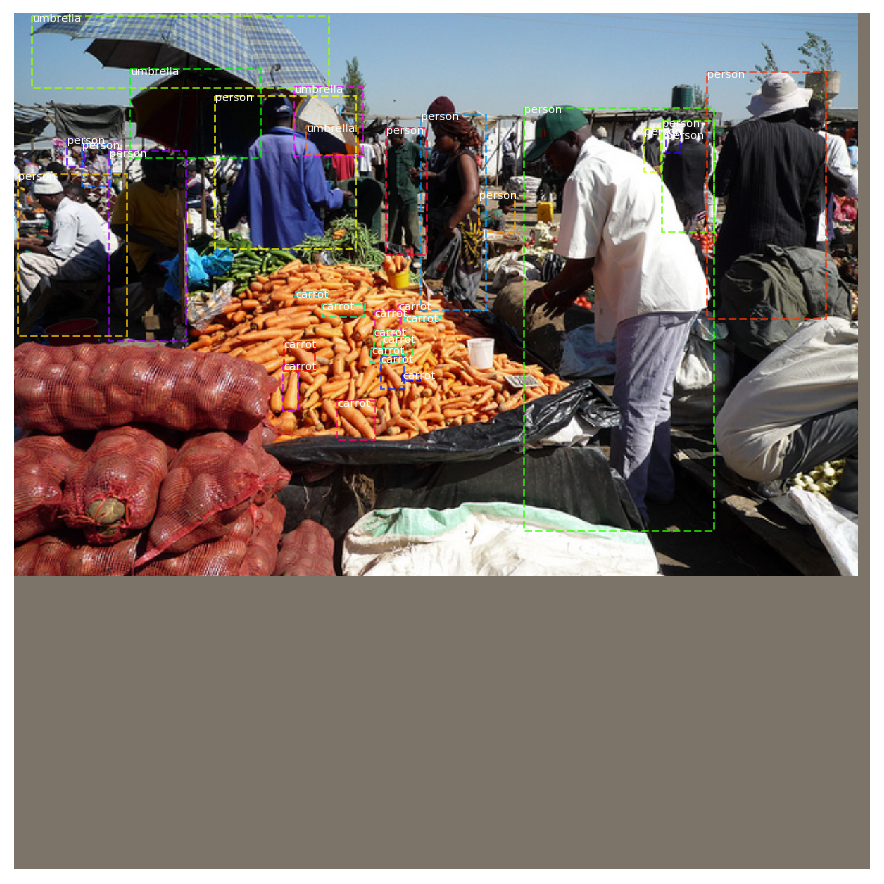

In [5]:
from detection.datasets.utils import get_original_image
img, img_meta, bboxes, labels = train_dataset[0]

rgb_img = np.round(img + img_mean)
ori_img = get_original_image(img, img_meta, img_mean)

visualize.display_instances(rgb_img, bboxes, labels, train_dataset.get_categories())

#### load model

In [6]:
from detection.models.detectors import faster_rcnn

model = faster_rcnn.FasterRCNN(
    num_classes=len(train_dataset.get_categories()))

In [7]:
batch_imgs = tf.Variable(np.expand_dims(img, 0))
batch_metas = tf.Variable(np.expand_dims(img_meta, 0))

_ = model((batch_imgs, batch_metas), training=False)

In [8]:
model.load_weights('/workspace/shared_workspace/faster_rcnn.h5', by_name=True)

In [9]:
proposals = model.simple_test_rpn(img, img_meta)
res = model.simple_test_bboxes(img, img_meta, proposals)

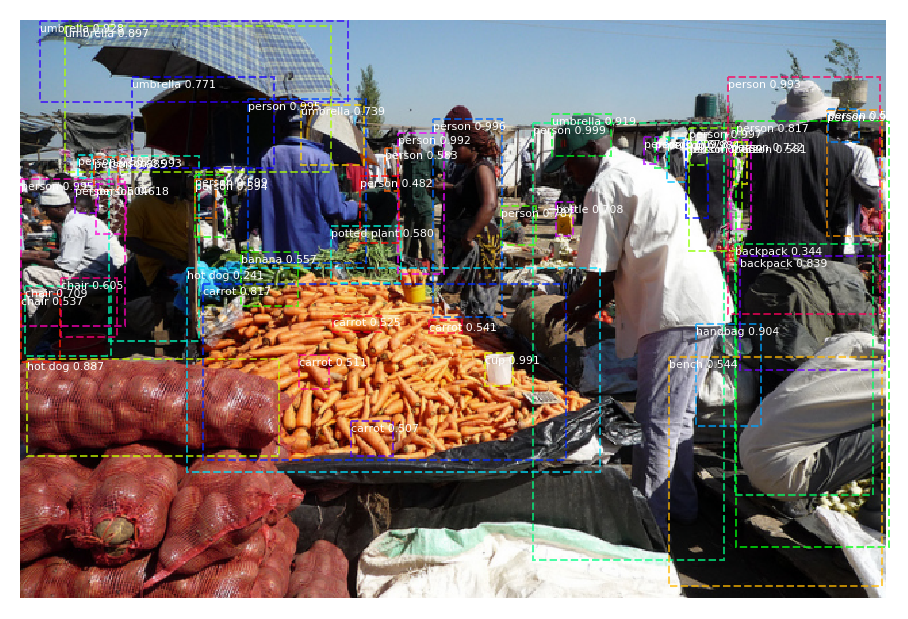

In [10]:
visualize.display_instances(ori_img, res['rois'], res['class_ids'], 
                            train_dataset.get_categories(), scores=res['scores'])

#### use tf.data

In [11]:
batch_size = 1

train_tf_dataset = tf.data.Dataset.from_generator(
    train_generator, (tf.float32, tf.float32, tf.float32, tf.int32))
train_tf_dataset = train_tf_dataset.padded_batch(
    batch_size, padded_shapes=([None, None, None], [None], [None, None], [None]))

#### overfit a sample

In [57]:
@tf.function(experimental_relax_shapes=True)
def train_step(inputs):
    batch_imgs, batch_metas, batch_bboxes, batch_labels = inputs
    with tf.GradientTape() as tape:
        rpn_class_loss, rpn_bbox_loss, rcnn_class_loss, rcnn_bbox_loss = \
            model((batch_imgs, batch_metas, batch_bboxes, batch_labels), training=True)

        loss_value = rpn_class_loss + rpn_bbox_loss + rcnn_class_loss + rcnn_bbox_loss

    grads = tape.gradient(loss_value, model.variables)
    grads = [grad if grad is not None else tf.zeros_like(var) for var, grad in zip(model.variables, grads)]
    optimizer.apply_gradients(zip(grads, model.variables))
    return loss_value

In [58]:
#optimizer = tf.train.MomentumOptimizer(1e-3, 0.9, use_nesterov=True)
optimizer = tf.keras.optimizers.SGD(1e-3, momentum=0.9, nesterov=True)

epochs = 100

for epoch in range(epochs):
    #iterator = train_tf_dataset.make_one_shot_iterator()

    loss_history = []
    #for (batch, inputs) in enumerate(iterator):
    for (batch, inputs) in enumerate(train_tf_dataset):
    
        '''batch_imgs, batch_metas, batch_bboxes, batch_labels = inputs
        with tf.GradientTape() as tape:
            rpn_class_loss, rpn_bbox_loss, rcnn_class_loss, rcnn_bbox_loss = \
                model((batch_imgs, batch_metas, batch_bboxes, batch_labels), training=True)

            loss_value = rpn_class_loss + rpn_bbox_loss + rcnn_class_loss + rcnn_bbox_loss
        

        grads = tape.gradient(loss_value, model.variables)
        grads = [grad if grad is not None else tf.zeros_like(var) for var, grad in zip(model.variables, grads)]
        optimizer.apply_gradients(zip(grads, model.variables))'''
        loss_value = train_step(inputs)

        loss_history.append(loss_value.numpy())
        break

    print('epoch', epoch, '-', np.mean(loss_history))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (<unknown>, line 26)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (<unknown>, line 26)


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting spars

epoch 0 - 1.5281256
epoch 1 - 1.3982472
epoch 2 - 1.1877563
epoch 3 - 1.2352874
epoch 4 - 1.1126806
epoch 5 - 1.0423352
epoch 6 - 0.9661801
epoch 7 - 0.91338074
epoch 8 - 1.1291819
epoch 9 - 0.99670637
epoch 10 - 0.74162453
epoch 11 - 0.81496274
epoch 12 - 0.8174627
epoch 13 - 0.7351936
epoch 14 - 0.70941305
epoch 15 - 0.59977734
epoch 16 - 0.47936875
epoch 17 - 0.50559545
epoch 18 - 0.558669
epoch 19 - 0.47583857
epoch 20 - 0.4961015
epoch 21 - 0.5073612
epoch 22 - 0.50829476
epoch 23 - 0.41496474
epoch 24 - 0.42103451
epoch 25 - 0.43271363
epoch 26 - 0.3759742
epoch 27 - 0.32444444
epoch 28 - 0.36118117
epoch 29 - 0.29953042
epoch 30 - 0.422054
epoch 31 - 0.5129601
epoch 32 - 0.3001069
epoch 33 - 0.25926727
epoch 34 - 0.30817086
epoch 35 - 0.31734604
epoch 36 - 0.29384574
epoch 37 - 0.24048594
epoch 38 - 0.26560977
epoch 39 - 0.23038472
epoch 40 - 0.25615755
epoch 41 - 0.20872203
epoch 42 - 0.29170144
epoch 43 - 0.23659545
epoch 44 - 0.2020156
epoch 45 - 0.23914516
epoch 46 - 0.22686

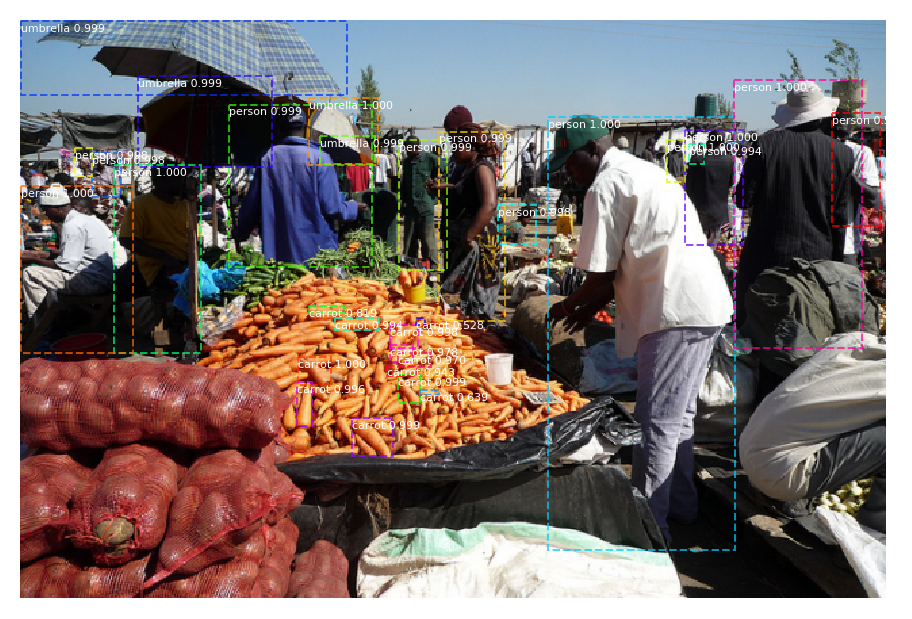

In [59]:
proposals = model.simple_test_rpn(img, img_meta)
res = model.simple_test_bboxes(img, img_meta, proposals)
visualize.display_instances(ori_img, res['rois'], res['class_ids'], 
                            train_dataset.get_categories(), scores=res['scores'])

#### train model

In [60]:
model.layers[0].save_weights('resnet_101_backbone.h5')

In [19]:
train_tf_dataset = tf.data.Dataset.from_generator(
    train_generator, (tf.float32, tf.float32, tf.float32, tf.int32))

In [20]:
batch_size = 2
train_tf_dataset = train_tf_dataset.prefetch(100).shuffle(100)
train_tf_dataset = train_tf_dataset.padded_batch(
                            batch_size,
                            padded_shapes=(
                            tf.TensorShape([None, None, 3]), # image padded to largest in batch
                            tf.TensorShape([11]),            # image meta - no padding
                            tf.TensorShape([None, 4]),       # bounding boxes, padded to longest
                            tf.TensorShape([None])           # labels, padded to longest
                            ),
                            padding_values=(0.0, 0.0, 0.0, -1))


In [21]:
model = faster_rcnn.FasterRCNN(
    num_classes=len(train_dataset.get_categories()), batch_size = batch_size)

In [22]:
for i in train_tf_dataset:
    _ = model(i)
    break

In [70]:
'''batch_imgs = tf.Variable(np.expand_dims(img, 0))
batch_metas = tf.Variable(np.expand_dims(img_meta, 0))

_ = model((batch_imgs, batch_metas), training=False)'''

'batch_imgs = tf.Variable(np.expand_dims(img, 0))\nbatch_metas = tf.Variable(np.expand_dims(img_meta, 0))\n\n_ = model((batch_imgs, batch_metas), training=False)'

In [24]:
model.layers[0].load_weights('resnet_101_backbone.h5')

In [25]:
model.layers[0].trainable=False

In [73]:
c2, c3, c4, c5 = model.backbone(batch_imgs, training=False)
p2, p3, p4, p5, p6 = model.neck((c2, c3, c4, c5), training=False)
rpn_logits, rpn_probs, rpn_deltas = model.rpn_head((p2, p3, p4, p5, p6), training=False)
anchors, valid_flags = model.rpn_head.generator.generate_pyramid_anchors(batch_metas)

In [74]:
#tf.math.top_k(rpn_probs[...,1][0], k=100)
boxes = tf.gather(anchors, tf.math.top_k(rpn_probs[...,1][0], k=100)[1])

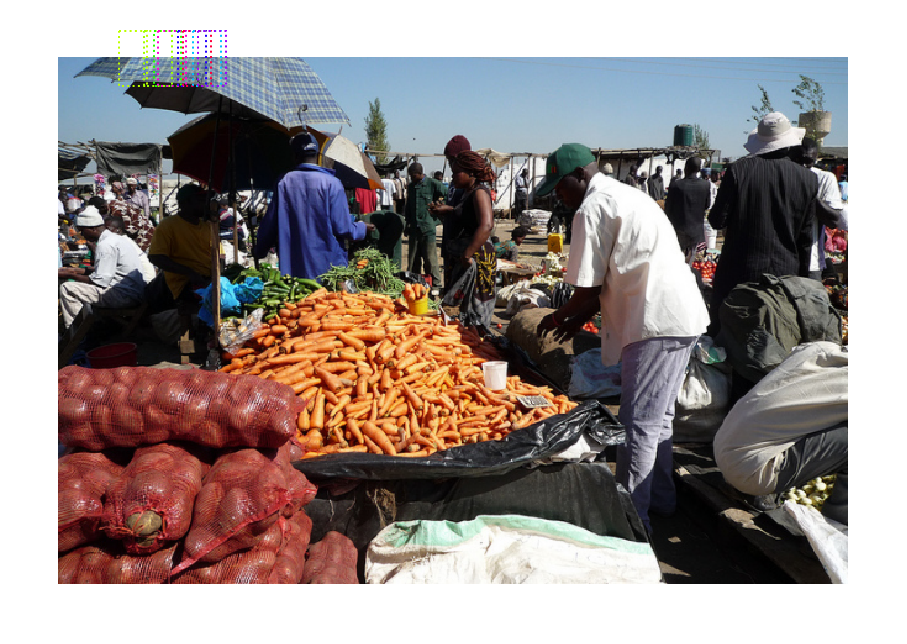

In [75]:
visualize.draw_boxes(ori_img, boxes.numpy())

In [77]:
'''proposals = model.simple_test_rpn(img, img_meta)
res = model.simple_test_bboxes(img, img_meta, proposals)
visualize.display_instances(ori_img, res['rois'], res['class_ids'], 
                            train_dataset.get_categories(), scores=res['scores'])'''

"proposals = model.simple_test_rpn(img, img_meta)\nres = model.simple_test_bboxes(img, img_meta, proposals)\nvisualize.display_instances(ori_img, res['rois'], res['class_ids'], \n                            train_dataset.get_categories(), scores=res['scores'])"

In [16]:
from tqdm.notebook import tqdm
import numpy as np

In [26]:
model.load_weights('rpn_training.h5')

In [27]:
@tf.function(experimental_relax_shapes=True)
def train_step(inputs):
    batch_imgs, batch_metas, batch_bboxes, batch_labels = inputs
    with tf.GradientTape() as tape:
        rpn_class_loss, rpn_bbox_loss, rcnn_class_loss, rcnn_bbox_loss = \
            model((batch_imgs, batch_metas, batch_bboxes, batch_labels), training=True)

        loss_value = rpn_class_loss + rpn_bbox_loss # + rcnn_class_loss + rcnn_bbox_loss

    grads = tape.gradient(loss_value, model.variables)
    grads = [grad if grad is not None else tf.zeros_like(var) for var, grad in zip(model.variables, grads)]
    optimizer.apply_gradients(zip(grads, model.variables))
    return loss_value

In [28]:
optimizer = tf.keras.optimizers.SGD(1e-5, momentum=0.9, nesterov=True)

epochs = 100

for epoch in range(epochs):
    loss_history = []
    progressbar = tqdm(enumerate(train_tf_dataset))
    for (batch, inputs) in progressbar:
        loss_history.append(train_step(inputs))
        progressbar.set_description("{}".format(np.array(loss_history[-100:]).mean()))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (<unknown>, line 26)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (<unknown>, line 26)


KeyboardInterrupt: 

In [29]:
model.save_weights('rpn_training.h5')

In [30]:
train_tf_dataset_iter = iter(train_tf_dataset)

In [57]:
imgs, metas, bboxes, labels = next(train_tf_dataset_iter)

In [58]:
c2, c3, c4, c5 = model.backbone(imgs, training=False)
p2, p3, p4, p5, p6 = model.neck((c2, c3, c4, c5), training=False)
rpn_logits, rpn_probs, rpn_deltas = model.rpn_head((p2, p3, p4, p5, p6), training=False)
anchors, valid_flags = model.rpn_head.generator.generate_pyramid_anchors(metas)

In [59]:
boxes = tf.gather(anchors, tf.math.top_k(rpn_probs[0,...,1], k=100)[1])

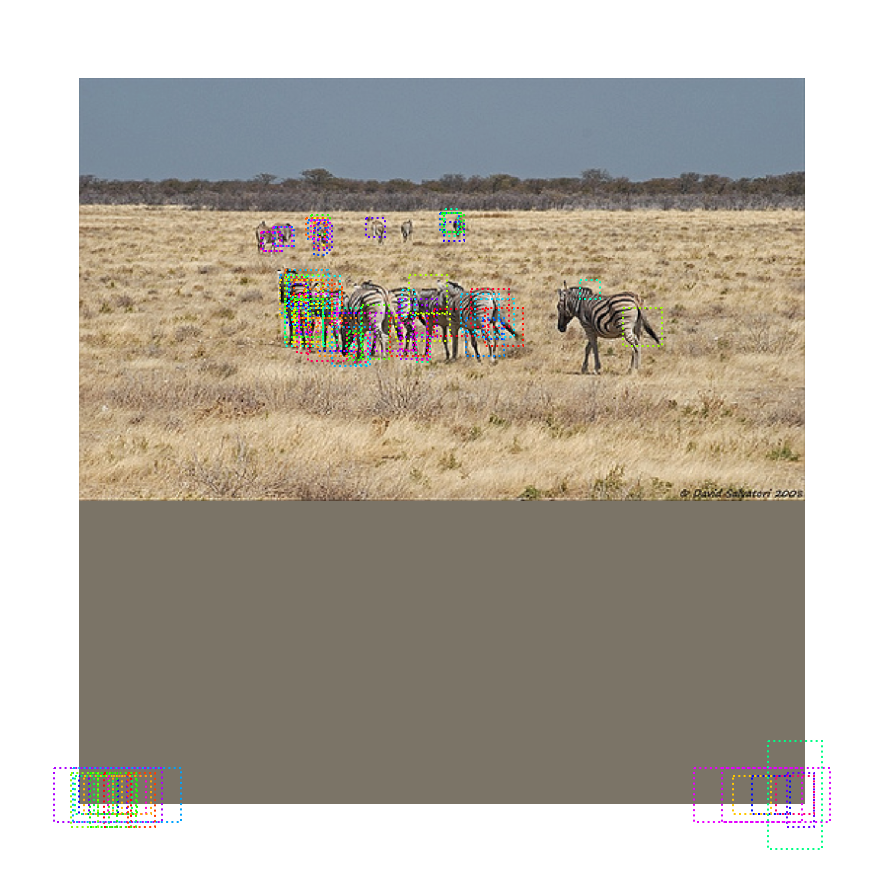

In [60]:
visualize.draw_boxes((imgs[0].numpy()+img_mean), boxes.numpy())

In [100]:
proposals = model.rpn_head.get_proposals(rpn_probs, rpn_deltas, metas)

In [101]:
proposals[:10]

<tf.Tensor: shape=(10, 5), dtype=float32, numpy=
array([[0.        , 0.        , 0.        , 0.09191434, 0.4466879 ],
       [0.        , 0.        , 0.9098849 , 0.07231211, 0.9184699 ],
       [0.        , 0.6324032 , 1.        , 0.67636955, 1.        ],
       [0.        , 0.6324032 , 1.        , 0.67636955, 1.        ],
       [0.        , 0.6324032 , 1.        , 0.67636955, 1.        ],
       [0.        , 0.6324032 , 1.        , 0.67636955, 1.        ],
       [0.        , 0.6324032 , 1.        , 0.67636955, 1.        ],
       [0.        , 0.6324032 , 1.        , 0.67636955, 1.        ],
       [0.        , 0.6324032 , 1.        , 0.67636955, 1.        ],
       [0.        , 0.6324032 , 1.        , 0.67636955, 1.        ]],
      dtype=float32)>

In [29]:
#optimizer = tf.train.MomentumOptimizer(1e-3, 0.9, use_nesterov=True)
optimizer = tf.keras.optimizers.SGD(1e-5, momentum=0.9, nesterov=True)

epochs = 100

for epoch in range(epochs):
    #iterator = train_tf_dataset.make_one_shot_iterator()

    loss_history = []
    rpn_class_loss_history = []
    rpn_bbox_loss_history = []
    rcnn_class_loss_history = []
    rcnn_bbox_loss_history = []
    #for (batch, inputs) in enumerate(iterator):
    progressbar = tqdm(enumerate(train_tf_dataset))
    for (batch, inputs) in progressbar:
    
        batch_imgs, batch_metas, batch_bboxes, batch_labels = inputs
        with tf.GradientTape() as tape:
            rpn_class_loss, rpn_bbox_loss, rcnn_class_loss, rcnn_bbox_loss = \
                model((batch_imgs, batch_metas, batch_bboxes, batch_labels), training=True)

            loss_value = rpn_class_loss + rpn_bbox_loss + rcnn_class_loss + rcnn_bbox_loss

        grads = tape.gradient(loss_value, model.variables)
        grads = [grad if grad is not None else tf.zeros_like(var) for var, grad in zip(model.variables, grads)]
        optimizer.apply_gradients(zip(grads, model.variables))

        loss_history.append(loss_value.numpy())
        rpn_class_loss_history.append(rpn_class_loss)
        rpn_bbox_loss_history.append(rpn_bbox_loss)
        rcnn_class_loss_history.append(rcnn_class_loss)
        rcnn_bbox_loss_history.append(rcnn_bbox_loss)
        '''progressbar.set_description("RPNC: {0:.5f} RPNB: {1:.5f} RCNC: {2:.5f} RCNB: {3:.5f}".format(np.array(rpn_class_loss_history).mean(),
                                                                                                     np.array(rpn_bbox_loss_history).mean(),
                                                                                                     np.array(rcnn_class_loss_history).mean(),
                                                                                                     np.array(rcnn_bbox_loss_history).mean()))'''
        progressbar.set_description("RPNC: {0:.4f} RPNB: {1:.4f}".format(np.array(rpn_class_loss_history).mean(), np.array(rpn_bbox_loss_history).mean()))

KeyboardInterrupt: 